# Challenge 01: Diagonal Unitary Circuit Composer
**Solution done by [Billy.Ljm](https://github.com/BillyLjm/QOSF-Monthly-Challenges)**  

Write a program that takes as an input a diagonal unitary matrix, and returns a corresponding quantum circuit. For example, given the unitary matrix $\Lambda \in \mathbb{R}^{4\times4}$ shown below, the composer would synthesize the following circuit:

<img src="images/composer_cir.png" width = 750/>

For this problem, you are not restricted to the use of a particular set of gates. Since different equivalent circuits can have the same unitary operator associated with them, your circuit for $\Lambda$ wouldn't have to necessarily look the same as the one above. For example, depending on your choice of gates, the same unitary $\Lambda$ above could result in circuits with more (or less) number of gates, like the ones shown below:

<img src="images/composer_cir2.png" width = 680/>

We have broken down this challenge in three levels of difficulty. You don't have to work on these separately nor complete all three of them; If you have an idea how to tackle Level 3, you can just go for it, but if not, solving first two first should help you get started.

**Level 1:** The composer should return a circuit for any unitary matrix $\Lambda \in \mathbb{R}^{4\times4}$. (i.e., $4 \times 4$ matrices with only real entries)

**Level 2:** The composer should return a circuit for any unitary matrix $\Lambda \in \mathbb{R}^{N\times N}$. (i.e., matrices of arbitrary size $N = 2^n$ with only real entries)

**Level 3:** The composer should return a circuit for any unitary matrix $\Lambda \in \mathbb{C}^{N\times N}$. (i.e., matrices of arbitrary size $N = 2^n$ with complex entries)

**Bonus:** The composer should return circuits consisting of only one-qubit and two-qubit gates. The bonus applies to solutions in levels 2 and 3.

The idea behind this challenge is for you to develop an understanding of how circuits can be built out of unitaries, so avoid using functions that do this for you automatically, like the `transpile` function in Qiskit, or the `decompose` function in Cirq.

**Hint:** If you have trouble getting started, it might be helpful to know that this problem is closely related to the design of Oracles for Grover's Algorithm [1].

[1] Figgatt, Caroline, et al. "Complete 3-Qubit Grover search on a programmable quantum computer." Nature communications 8.1 (2017): 1-9. [arXiv:1703.10535](https://arxiv.org/pdf/1703.10535.pdf)

## My Approach: CX-RZ-CX
*The [Qiskit textbook](https://qiskit.org/textbook/ch-gates/proving-universality.html) has a nice introduction on the universality of quantum gates, and how general unitary matrices can be implemented with $\sigma$, $R_x$*

Any unitary matrix $U$ can be rewritten as an exponential of a hermitiain matrix $H$  
This $H$ in turn can be decomposed in terms of the Pauli matrices $\sigma_i$  

$$\begin{aligned}
    U 
    &= \exp(iH)\\
    &= \exp \left[ i  \sum_j C_j \left( \sigma^{\otimes n} \right)_{j} \right]\\
    &= \exp[i C_1 (Z \otimes Z \otimes \ldots) + i C_2 (Y \otimes Z \otimes \ldots) + \ldots]
\end{aligned}$$

Since our $U$ is diagonal, the corresponding $H$ can be easily extracted by reversing the [Euler formula](https://en.wikipedia.org/wiki/Euler%27s_formula) element-wise  

$$U_{ii} = \cos(H_{ii}) + i \sin(H_{ii})$$

Additionally, our $H$ is also diagonal and can be decomposed exclusively into $I$ and $Z$ which commute.  
This allows our matrix exponential to be separated, and implemented in sections without [Trotterization](https://en.wikipedia.org/wiki/Time-evolving_block_decimation#The_Suzuki-Trotter_expansion)  

$$\begin{aligned}
    U_{\text{diag}}
    &= \exp \left[ i \sum_j C_j \left( \sigma_{\{I,Z\}}^{\otimes n} \right)_{j} \right]\\
    &= \prod_j \exp \left[ i C_j \left( \sigma_{\{I,Z\}}^{\otimes n} \right)_{j} \right] \ (\because [I, Z] = 0)\\
    &= \exp[i C_1 (Z \otimes Z \otimes \ldots)] \times \exp[i C_2 (I \otimes Z \otimes \ldots)] \times \ldots
\end{aligned}$$

To implement each of these sectioned exponentials, we can simply sandwich `Rz` between `cX` gates

$$\begin{aligned}
    &CX(i,j) \ R_z(j, \theta) \ CX(i,j)\\
    &= \exp \left[ -i \frac{\theta}{2} CX(i,j) \ (I_i \otimes Z_j) \ CX(i,j) \right]\\
    &= \exp \left[ -i \frac{\theta}{2} (Z_i \otimes Z_j) \right]\\
\end{aligned}$$

This outlines my approach, which I'll proceed to implement in the rest of this notebook.  

### Pauli Decomposition
For Pauli decomposition, we can simply multiply the matrix with each Pauli operator and trace the resulting matrix to obtain the coefficients.  

$$\begin{aligned}
    Tr(A \sigma_i)
    &= Tr \left[ \left( \sum_j C_j \sigma_j \right) \sigma_i \right]\\
    &= Tr(C_i \sigma_i^2) + \sum_{j \neq i} Tr(C_j \sigma_i \sigma_j)\\
    &= Tr(C_i I) + \sum_k Tr(C_j \sigma_k)\\
    &= C_i \times \text{dim}(A) \ (\because Tr(\sigma) = 0)
\end{aligned}$$

In [1]:
import itertools
import numpy as np
np.set_printoptions(precision=3)

In [2]:
def PauliOperator(label):
    """Generates a specified Pauli operator
    
    Parameters:
        label (str): Pauli operator label (e.g. 'ZZZZIIIX')
        
    Returns:
        numpy matrix of corresponding Pauli operator
    """
    pauli = {
        'I': np.matrix([[1,0],[0,1]]),
        'Z': np.matrix([[1,0],[0,-1]]),
        'X': np.matrix([[0,1],[1,0]]),
        'Y': np.matrix([[0,-1j],[1j,0]])
    }
    
    operator = pauli[label[0]]
    for letter in label[1:]:
        operator = np.kron(operator, pauli[letter])

    return operator

# demo
PauliOperator('IX')

matrix([[0, 1, 0, 0],
        [1, 0, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 1, 0]])

In [3]:
def PauliDecompose(hmat):
    """Decompose a Hermitian matrix into a sum of Pauli matrices
    
    Parameters:
        hmat (matrix): hermitian matrix to decompose
        
    Returns:
        dictionary of {Pauli matrix(str) : coefficient (float)}
    """
    coeff = {}
    nbits = int(np.log2(hmat.shape[0]))
    labels = itertools.product('IXYZ', repeat=nbits)
    labels = [''.join(i) for i in labels]
    for label in labels:
        tmp = np.matmul(hmat, PauliOperator(label))
        coeff[label] = np.trace(tmp) / hmat.shape[0]
    
    return coeff

# demo
PauliDecompose(PauliOperator('I') + PauliOperator('Z'))

{'I': 1.0, 'X': 0.0, 'Y': 0j, 'Z': 1.0}

### Circuit Implementation (Qiskit)
We'll combine everything to realise an abritrary unitary matrix in a quantum circuit, using Qiskit

In [4]:
from qiskit import QuantumCircuit, Aer, execute

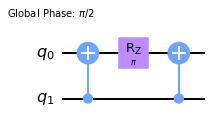

In [5]:
def UGate(umat):
    """Realises the specified unitary digonal matrix in a Qiskit quantum cricuit
    
    Parameters:
        umat (matrix): unitary diagonal matrix to realise
        
    Returns:
        QuantumCircuit which implements the unitary
    """
    # check input
    nbits = np.log2(umat.shape[0])
    if umat.shape[0] != umat.shape[1] or not nbits.is_integer:
        raise Exception('matrix has incorrect dimensions')
    elif not np.allclose(np.matmul(umat,np.conj(umat)), np.identity(umat.shape[0])):
        raise Exception('matrix is not unitary')
    elif not np.allclose(umat, np.diag(np.diagonal(umat))):
        raise Exception('matrix is not diagonal')
    nbits = int(nbits)
    
    # Pauli decompose
    hmat = np.angle(umat)
    components = PauliDecompose(hmat)
    
    # order to implement Pauli component (reduces CNOTs used)
    
    # iteratively add each pauli component
    qc = QuantumCircuit(nbits, global_phase=components['I'*nbits])# manually implment II...
    for operator, coeff in components.items():
        # find qubits to CX-RZ-CX
        cxlist = []
        for i in range(len(operator)):
            cxlist.append(i) if operator[i] == 'Z' else None
        cxlist = [nbits - 1 - i for i in cxlist] # because of qiskit's weird reverse qubits
        # skip if no coeff (or II..., implemented above)
        if coeff == 0 or len(cxlist) == 0:
            continue
        elif len(cxlist) == 1: # apply CZ
            qc.rz(-2*coeff, cxlist[0])
        else: # apply CX-RZ-CZ
            for ctrl in cxlist[:-1]:
                qc.cx(ctrl, cxlist[-1])
            qc.rz(-2*coeff, cxlist[-1])
            for ctrl in reversed(cxlist[:-1]):
                qc.cx(ctrl, cxlist[-1])
    
    return qc

# demo
UGate(np.diag([1,-1,-1,1])).draw(output="mpl")

To test the function on a random unitary diagonal matrix,

input U:  [-0.124-0.992j  0.389+0.921j -0.907+0.42j  -0.397+0.918j -0.292-0.956j
 -0.802-0.597j -0.755-0.656j  0.826+0.564j -0.785-0.619j -0.247+0.969j
 -0.89 -0.455j -0.735+0.678j -0.372-0.928j  0.946-0.324j  0.833+0.553j
  0.528+0.849j -0.986-0.169j -0.615-0.789j  0.978-0.209j  0.441+0.898j
  0.963-0.27j   0.984-0.18j  -0.482+0.876j -0.016-1.j    -0.982+0.189j
 -0.464-0.886j -0.885+0.465j  0.768-0.64j  -0.989+0.147j  0.206-0.979j
  0.114+0.994j -0.836-0.549j]
output U:  [-0.124-0.992j  0.389+0.921j -0.907+0.42j  -0.397+0.918j -0.292-0.956j
 -0.802-0.597j -0.755-0.656j  0.826+0.564j -0.785-0.619j -0.247+0.969j
 -0.89 -0.455j -0.735+0.678j -0.372-0.928j  0.946-0.324j  0.833+0.553j
  0.528+0.849j -0.986-0.169j -0.615-0.789j  0.978-0.209j  0.441+0.898j
  0.963-0.27j   0.984-0.18j  -0.482+0.876j -0.016-1.j    -0.982+0.189j
 -0.464-0.886j -0.885+0.465j  0.768-0.64j  -0.989+0.147j  0.206-0.979j
  0.114+0.994j -0.836-0.549j]
identical:  True


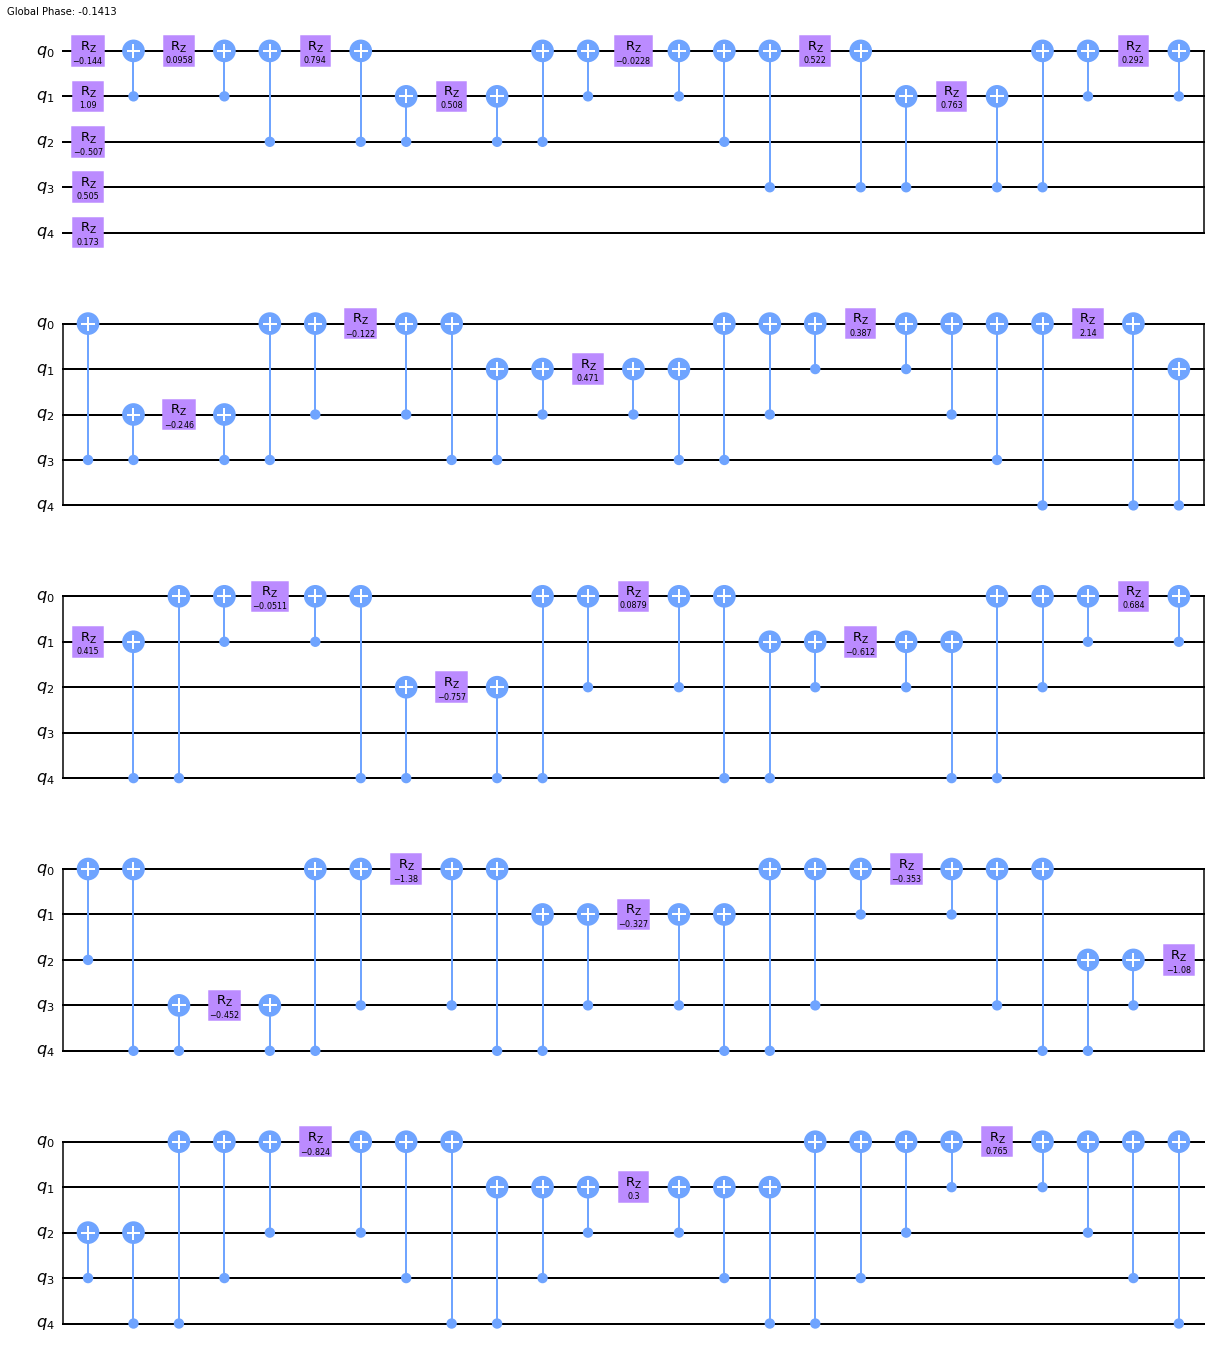

In [6]:
nbits = 5

# generate random unitary diagonal matrix
umat = np.random.rand(2**nbits)
umat = np.exp(2j * np.pi * umat)
umat = np.diag(umat)

# simulate generated circuit
qc = UGate(umat)
backend = Aer.get_backend('unitary_simulator')
job = execute(qc, backend)
out = job.result().get_unitary()

# compare input & output
print("input U: ", np.diagonal(umat))
print("output U: ", np.diagonal(out))
print("identical: ", np.allclose(umat, out))
qc.draw(output="mpl")